In [1]:
import fractions
from fractions import Fraction as Q
import matplotlib as mpl
import matplotlib.pyplot as plt

# Simplex with dictionaries
## Using rational numbers and relatively nice output
No Phase I implemented, assuming a (primally or dually) feasible initial basis.

In [2]:
def raw_num(q):
    result = ''
    if q.denominator == 1:
        return str(q.numerator)
    if q.numerator < 0:
        result += '-'
        result += r'\frac{' + str(-q.numerator) + "}{" + str(q.denominator) + "}"
    else:
        result += r'\frac{' + str(q.numerator) + "}{" + str(q.denominator) + "}"
    return result


def op_and_num(q, varname):
    if q == 0:
        return "&{}&{}"
    result = '&{}' + ("-{}&" if q < 0 else "+{}&")
    qq = (q if q >= 0 else -q)
    if qq.denominator == 1:
        return result + str(qq.numerator) + " " + varname
    else:
        return result + r'\frac{' + str(qq.numerator) + '}{' + str(qq.denominator) + "} " + varname
    

class SimplexDictionary:
    def varname(self, index):
        if index < self.num_original_vars:
            return f"x_{{{index + 1}}}"
        if index < self.num_original_vars + self.num_original_constrs:
            return f"w_{{{index - self.num_original_vars + 1}}}"
        return f"g_{{{index - self.num_original_vars - self.num_original_constrs + 1}}}"
    
    def __init__(self, A, b, c):
        self.num_rows = len(A)
        self.num_cols = len(c)
        self.num_original_vars = len(c)
        self.num_original_constrs = len(A)
        self.original_A = A
        self.original_b = b
        self.original_c = c
        self.original_cut_defs = {}
        self.nonbasic = list(range(self.num_original_vars))
        self.basic = list(range(self.num_original_vars, self.num_original_vars + self.num_original_constrs))
        self.bas_obj_val = Q(0,1)
        self.bas_vals = [Q(b[i]) for i in range(len(A))]
        self.obj_coeffs = [Q(c[i]) for i in range(len(c))]
        self.coeffs = [[Q(-A[row][col]) for col in range(len(c))] for row in range(len(A))]
        
    def is_primal_feasible(self):
        return all(x >= 0 for x in self.bas_vals)
    
    def is_dual_feasible(self):
        return all(x <= 0 for x in self.obj_coeffs)
    
    def add_cut(self, a, b):
        varidx = self.num_rows + self.num_cols
        self.basic.append(varidx)
        self.original_cut_defs[varidx] = ([(a[i], self.nonbasic[i]) for i in range(self.num_cols)],b)
        self.num_rows += 1
        self.bas_vals.append(b)
        self.coeffs.append([Q(-x) for x in a])
    
    def _pivot_row(self, entering_nb_index, leaving_b_index):
        div = -self.coeffs[leaving_b_index][entering_nb_index]
        self.bas_vals[leaving_b_index] /= div
        self.coeffs[leaving_b_index][entering_nb_index] = Q(-1)
        for i in range(self.num_cols):
            self.coeffs[leaving_b_index][i] /= div
            
    def _pivot_objective(self, entering_nb_index, leaving_b_index):
        fac = self.obj_coeffs[entering_nb_index]
        constant_term = self.bas_vals[leaving_b_index]
        self.bas_obj_val += fac * constant_term
        for i in range(self.num_cols):
            if i != entering_nb_index:
                self.obj_coeffs[i] += fac * self.coeffs[leaving_b_index][i]
            else:
                self.obj_coeffs[i] = fac * self.coeffs[leaving_b_index][entering_nb_index]
    
    def _pivot_other_row(self, row_index, entering_nb_index, leaving_b_index):
        row = self.coeffs[row_index]
        fac = row[entering_nb_index]
        if fac == 0: return
        constant_term = self.bas_vals[leaving_b_index]
        self.bas_vals[row_index] += fac * constant_term
        for i in range(self.num_cols):
            if i != entering_nb_index:
                row[i] += fac * self.coeffs[leaving_b_index][i]
            else:
                row[i] = fac * self.coeffs[leaving_b_index][entering_nb_index]
    
    def pivot(self, entering_nb_index, leaving_b_index):
        # relabel variables
        entering_var = self.nonbasic[entering_nb_index]
        leaving_var = self.basic[leaving_b_index]
        self.nonbasic[entering_nb_index] = leaving_var
        self.basic[leaving_b_index] = entering_var
        
        # rearrange the pivot row
        self._pivot_row(entering_nb_index, leaving_b_index)
        
        # deal with the objective row
        self._pivot_objective(entering_nb_index, leaving_b_index)
        
        # deal with the other rows
        for i in range(self.num_rows):
            if i != leaving_b_index:
                self._pivot_other_row(i, entering_nb_index, leaving_b_index)
    
    def _largest_coefficient_rule(self):
        argmax = max(range(self.num_cols), key=lambda i: self.obj_coeffs[i])
        if self.obj_coeffs[argmax] <= 0:
            raise RuntimeError("Largest coefficient rule with dual feasible dictionary!")
        return argmax
    
    def _largest_infeasibility_rule(self):
        argmin = min(range(self.num_rows), key=lambda i: self.bas_vals[i])
        if self.bas_vals[argmin] >= 0:
            raise RuntimeError("Largest infeasibility rule with primal feasible dictionary!")
        return argmin
    
    def _identify_leaving(self, entering_nb_index):
        leaving = None
        step_length = None
        for row in range(self.num_rows):
            c = self.coeffs[row][entering_nb_index]
            if c < 0:
                this_step_length = self.bas_vals[row] / -c
                if leaving is None or this_step_length < step_length:
                    leaving = row
                    step_length = this_step_length
        return leaving

    def _identify_entering(self, leaving_b_index):
        entering = None
        step_length = None
        for col in range(self.num_cols):
            c = self.coeffs[leaving_b_index][col]
            if c > 0:
                this_step_length = -self.obj_coeffs[col] / c
                if entering is None or this_step_length < step_length:
                    entering = col
                    step_length = this_step_length
        return entering
    
    def primal_simplex_step(self, entering_rule="largest_coefficient"):
        if not self.is_primal_feasible():
            raise RuntimeError("Primal simplex steps require primal feasibility!")
        if self.is_dual_feasible():
            return 'optimal'
        entering_rules = {"largest_coefficient": self._largest_coefficient_rule}
        entering_nb_index = entering_rules[entering_rule]()
        leaving_b_index = self._identify_leaving(entering_nb_index)
        if leaving_b_index is None:
            return 'unbounded'
        self.pivot(entering_nb_index, leaving_b_index)
        return 'feasible' if not self.is_dual_feasible() else 'optimal'
    
    def dual_simplex_step(self, leaving_rule="largest_infeasibility"):
        if not self.is_dual_feasible():
            raise RuntimeError("Dual simplex steps require dual feasibility!")
        if self.is_primal_feasible():
            return 'optimal'
        leaving_rules = {"largest_infeasibility": self._largest_infeasibility_rule}
        leaving_b_index = leaving_rules[leaving_rule]()
        entering_nb_index = self._identify_entering(leaving_b_index)
        if entering_nb_index is None:
            return 'infeasible'
        self.pivot(entering_nb_index, leaving_b_index)
        return 'dual_feasible' if not self.is_primal_feasible() else 'optimal'

    def display(self, obj_symbol=r"\zeta"):
        # display
        from IPython.display import display, Math
        content = r"\begin{gather*}\begin{aligned}"
        content += obj_symbol + " &{}={}& " + raw_num(self.bas_obj_val)
        for i in range(self.num_cols):
            content += op_and_num(self.obj_coeffs[i], self.varname(self.nonbasic[i]))
        content += r"\\\hline" + "\n"
        for row in range(self.num_rows):
            content += self.varname(self.basic[row]) + "&{}={}&" + raw_num(self.bas_vals[row])
            for col in range(self.num_cols):
                content += op_and_num(self.coeffs[row][col], self.varname(self.nonbasic[col]))
            content += r"\\" + "\n"
        content += r"\end{aligned}\end{gather*}"
        display(Math(content))
        
    def _add_to(self, current_vars, var, val):
        if var not in current_vars:
            current_vars[var] = val
        else:
            current_vars[var] += val

    def to_original_vars(self, a, b):
        """
        Turn a cut (indices in `a` combining the current non-basic variables)
        into the form ax <= b, but using only the original variables.
        """
        highest = lambda cv: max(k for k in cv)
        
        current_b = b
        current_vars = {self.nonbasic[i]: a[i] for i in range(self.num_cols)}

        while highest(current_vars) >= self.num_original_vars:
            eliminate = highest(current_vars)
            value = current_vars[eliminate]
            if value == 0:
                del current_vars[eliminate]
                continue

            if eliminate >= self.num_original_vars + self.num_original_constrs:
                # this is a cut's slack; look up the cut's definition
                a_with_vars, cut_b = self.original_cut_defs[eliminate]
                current_b -= value * cut_b
                for a_i, x_i in a_with_vars:
                    self._add_to(current_vars, x_i, -value * a_i)
                del current_vars[eliminate]
                continue
            
            # this is an original constraint's slack
            constr_idx = eliminate - self.num_original_vars
            current_b -= value * self.original_b[constr_idx]
            for i in range(self.num_original_vars):
                a_i = self.original_A[constr_idx][i]
                if a_i == 0: continue
                self._add_to(current_vars, i, -value * a_i)
            del current_vars[eliminate]
        value_of = lambda i: (Q(0) if i not in current_vars else current_vars[i])
        orig_a = [value_of(i) for i in range(self.num_original_vars)]            
        return orig_a, current_b

# Primal Simplex Example

In [3]:
A = [[1,2,3], [2,3,4], [5,0,1], [5,5,-1]]
b = [1, 2, 7, 8]
c = [2, 5, -3]

d = SimplexDictionary(A, b, c)
d.display()
d.primal_simplex_step()
d.display()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Dual Simplex Example

In [4]:
A = [[-2,-1], [-2,4], [-1, 3]]
b = [4, -8, -7]
c = [-1,-1]
d2 = SimplexDictionary(A, b, c)
d2.display()
d2.dual_simplex_step()
d2.display()
d2.dual_simplex_step()
d2.display()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Gomory Cut example
## Initial solve (primal simplex, 3 iterations)

In [5]:
A = [[10, -2], [4, 10], [-2, 10]]
b = [32, 38, 29]
c = [8, 13]
# additionally, x_1, x_2 (and hence all slacks) should be integer!
dg = SimplexDictionary(A, b, c)
dg.display()
dg.primal_simplex_step()
dg.display()
dg.primal_simplex_step()
dg.display()
dg.primal_simplex_step()
dg.display()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
def is_feasible_for_row(a, b, x, y):
    return a[0] * x + a[1] * y <= b

def is_feasible_point(A, b, x, y):
    return all(is_feasible_for_row(A[r], b[r], x, y) for r in range(len(A)))

def feasible_points(A, b, r1, r2):
    xs = []
    ys = []
    for x in range(r1[0], r1[1] + 1):
        for y in range(r2[0], r2[1] + 1):
            if is_feasible_point(A, b, x, y):
                xs.append(x)
                ys.append(y)
    return xs, ys

def row_to_line(a, b, **kwargs):
    if a[0] == 0:
        p1 = (0, float(b / a[1]))
        p2 = (1, float(b / a[1]))
    elif a[1] == 0:
        p1 = (float(b / a[0]), 0)
        p2 = (float(b / a[0]), 1)
    else:
        p1 = (0, float(b / a[1]))
        p2 = (float(b / a[0]), 0)
    plt.axline(p1, p2, **kwargs)

def plot_2d_integer_system(A, b, r1, r2, cuts=None):
    xs, ys = feasible_points(A, b, r1, r2)
    plt.scatter(xs, ys)
    row_to_line([-1, 0], 0)
    row_to_line([0, -1], 0)
    for r in range(len(A)):
        row_to_line(A[r], b[r])
    if cuts is not None:
        for cut in cuts:
            row_to_line(*cut, color="orange")

(-0.1, 5.0)

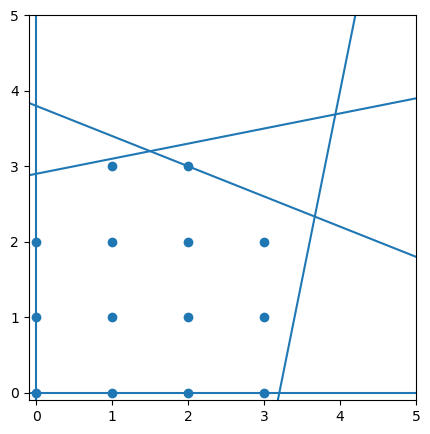

In [7]:
plot_2d_integer_system(A, b, (0,20), (0,20))
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(5,5)
ax.set_xlim(-0.1,5)
ax.set_ylim(-0.1,5)

## Introducing First Gomory Cut

In [8]:
def round_down(q: Q):
    if q.denominator == 1:
        return int(q.numerator)
    if q < 0:
        return int(q) - 1
    else:
        return int(q)

def most_nonintegral(dictionary: SimplexDictionary):
    compute_nonintegrality = lambda q: min(q - round_down(q), round_down(q) + 1 - q)
    nonintegrality_by_index = lambda i: compute_nonintegrality(dictionary.bas_vals[i])
    argmax = max(range(dictionary.num_rows), key=nonintegrality_by_index)
    if nonintegrality_by_index(argmax) == 0:
        return None
    return argmax

def compute_gomory_cut(dictionary: SimplexDictionary, basic_index=None):
    # if no index is given, we take the most non-integral (farthest from integrality)
    if basic_index is None:
        basic_index = most_nonintegral(dictionary)
        if basic_index is None:
            return 'integral'
        
    num_cols = dictionary.num_cols

    # now, the index should definitely point to a variable with non-integral basic value
    current_value = dictionary.bas_vals[basic_index]
    if int(current_value) == current_value:
        raise ValueError("The current solution value of the given index is already integral!")
    
    # compute the cut: rounding to get preliminary a and b (still have to add definition of basic var)
    b = round_down(current_value)
    a = [round_down(-dictionary.coeffs[basic_index][col]) for col in range(num_cols)]
    # add the definition of the basic variable
    b -= current_value  # means subtracting from RHS
    for col in range(num_cols):
        a[col] += dictionary.coeffs[basic_index][col]
    # a^Tx <= b is a Gomory cutting plane
    return (a,b)

def display_cut(dictionary, a, b, var_names=None):
    # display
    from IPython.display import display, Math
    content = ''
    for i in range(len(a)):
        if a[i] == 0: continue
        if content != '':
            content += ' + '
        if var_names is None:
            var = dictionary.nonbasic[i]
            varname = dictionary.varname(var)
        else:
            varname = var_names[i]
        content += raw_num(a[i])
        content += varname
    content += r' \leq '
    content += raw_num(b)
    display(Math(content))

In [9]:
a1,b1 = compute_gomory_cut(dg, 1)
display_cut(dg, a1, b1)

<IPython.core.display.Math object>

In [10]:
orig_cuts = [dg.to_original_vars(a1, b1)]
display_cut(dg, *orig_cuts[0], var_names=["x_1", "x_2"])

<IPython.core.display.Math object>

(-0.1, 5.0)

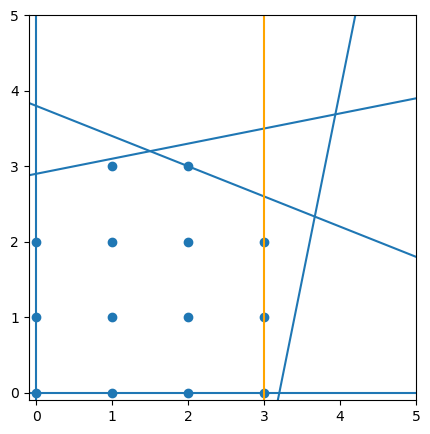

In [11]:
plot_2d_integer_system(A, b, (0,20), (0,20), cuts=orig_cuts)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(5,5)
ax.set_xlim(-0.1,5)
ax.set_ylim(-0.1,5)

In [12]:
dg.add_cut(a1,b1)
dg.display()

<IPython.core.display.Math object>

In [13]:
dg.is_primal_feasible(), dg.is_dual_feasible()

(False, True)

In [14]:
dg.dual_simplex_step()
dg.display()

<IPython.core.display.Math object>

In [15]:
a2,b2 = compute_gomory_cut(dg, 2)
display_cut(dg, a2, b2)
orig_a,orig_b = dg.to_original_vars(a2,b2)
orig_cuts.append((orig_a,orig_b))
display_cut(dg, orig_a, orig_b, var_names=["x_1","x_2"])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(-0.1, 5.0)

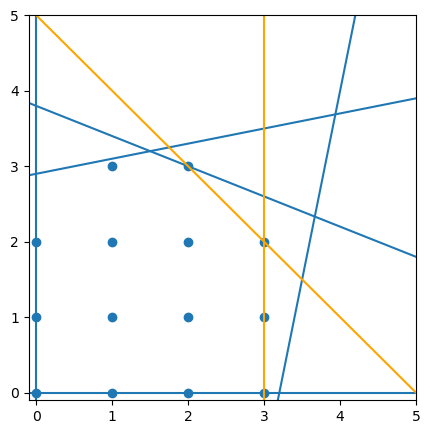

In [16]:
plot_2d_integer_system(A, b, (0,20), (0,20), cuts=orig_cuts)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(5,5)
ax.set_xlim(-0.1,5)
ax.set_ylim(-0.1,5)

In [17]:
dg.add_cut(a2,b2)
dg.display()
dg.dual_simplex_step()
dg.display()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [18]:
compute_gomory_cut(dg)

'integral'

# Example with very bad Gomory cuts

In [19]:
Abug = [[-2,-3], [-4, -2], [-3, -4], [1, 0], [0,1]]
bbug = [-5, -15, -20, 9, 6]
cbug = [-20, -15]
dbug = SimplexDictionary(Abug, bbug, cbug)
dbug.display()

<IPython.core.display.Math object>

In [20]:
while not dbug.is_primal_feasible():
    dbug.dual_simplex_step()
    dbug.display()
dbug.is_primal_feasible()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

True

(-5.0, 10.0)

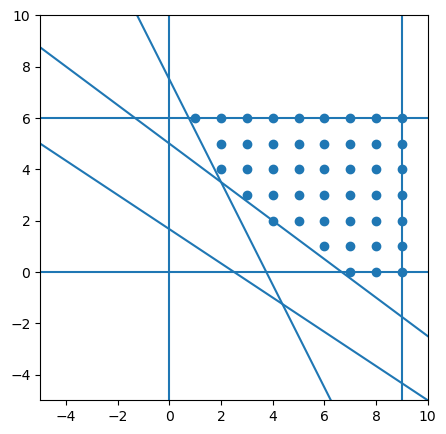

In [21]:
bug_cuts = []
plot_2d_integer_system(Abug, bbug, (0,20), (0,20), cuts=bug_cuts)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(5,5)
ax.set_xlim(-5,10)
ax.set_ylim(-5,10)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(-5.0, 10.0)

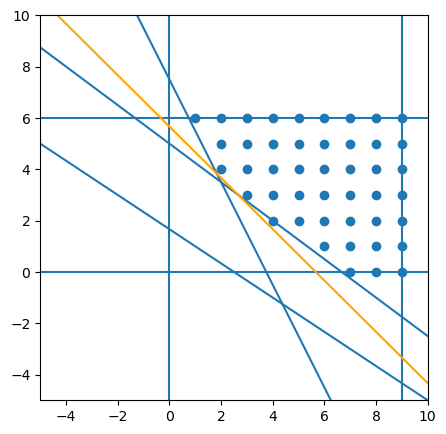

In [22]:
cut1 = compute_gomory_cut(dbug, 2)
display_cut(dbug, *cut1)
ocut1 = dbug.to_original_vars(*cut1)
display_cut(dbug, *ocut1, var_names=["x_1", "x_2"])
bug_cuts.append(ocut1)
plot_2d_integer_system(Abug, bbug, (0,20), (0,20), cuts=bug_cuts)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(5,5)
ax.set_xlim(-5,10)
ax.set_ylim(-5,10)

In [23]:
dbug.add_cut(*cut1)
dbug.display()
dbug.is_primal_feasible(), dbug.is_dual_feasible()

<IPython.core.display.Math object>

(False, True)

In [24]:
while not dbug.is_primal_feasible():
    dbug.dual_simplex_step()
    dbug.display()
dbug.is_primal_feasible()

<IPython.core.display.Math object>

True

<IPython.core.display.Math object>

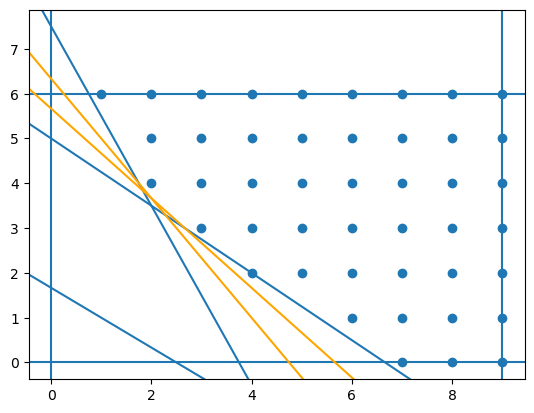

<IPython.core.display.Math object>

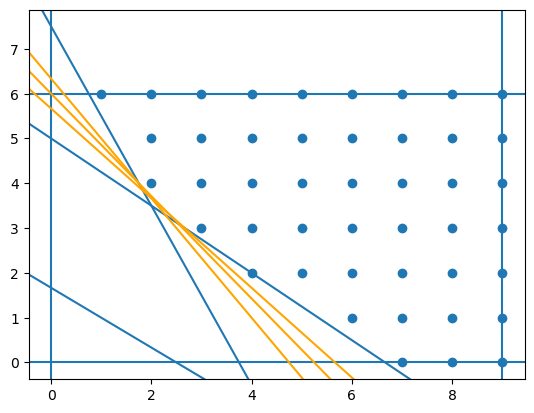

<IPython.core.display.Math object>

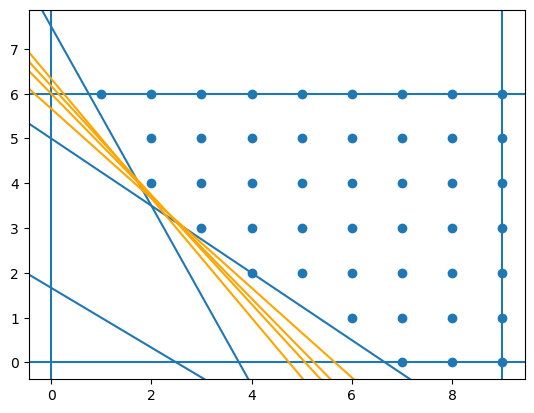

<IPython.core.display.Math object>

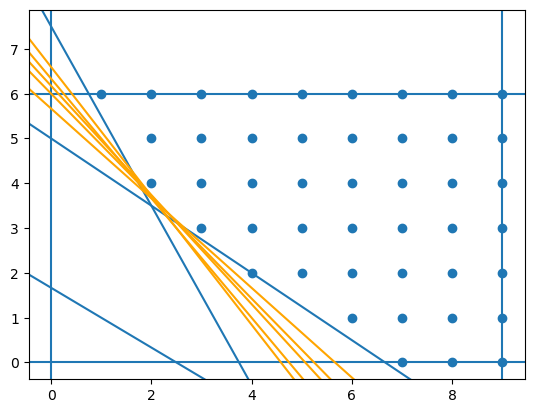

<IPython.core.display.Math object>

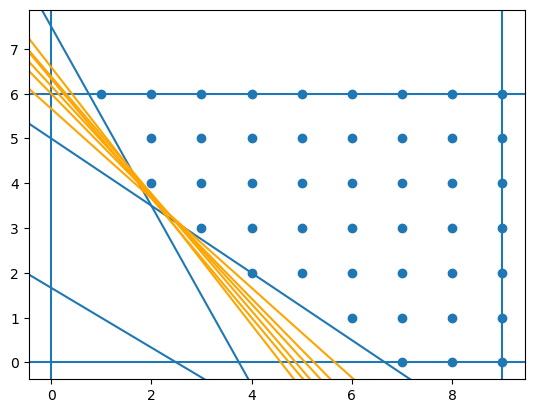

<IPython.core.display.Math object>

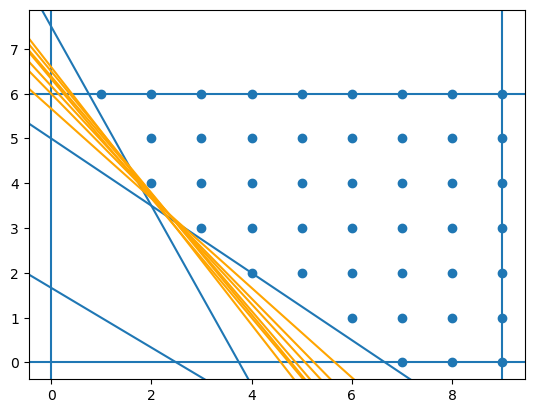

<IPython.core.display.Math object>

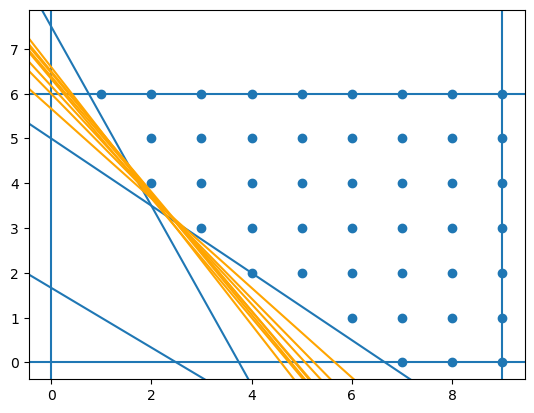

<IPython.core.display.Math object>

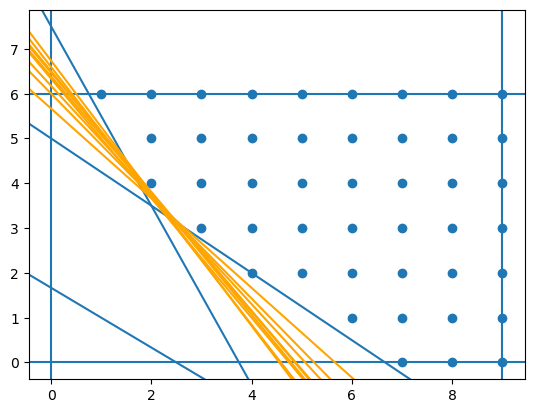

<IPython.core.display.Math object>

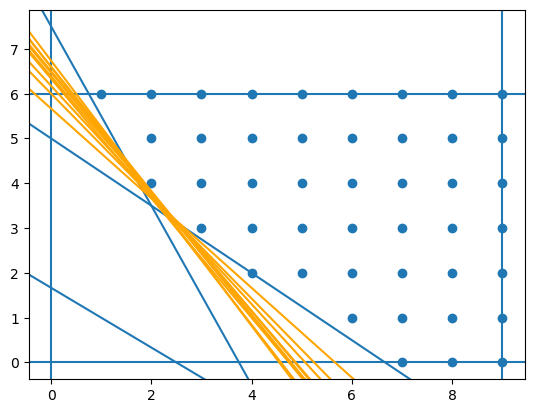

<IPython.core.display.Math object>

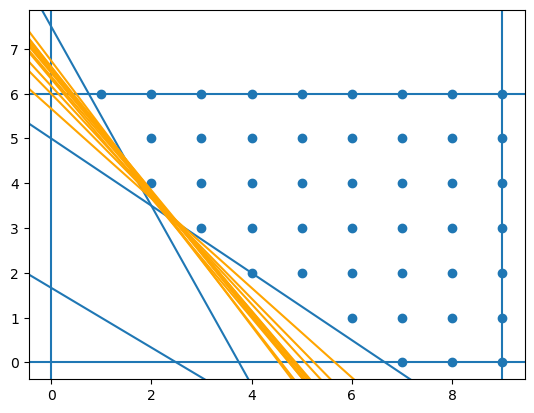

<IPython.core.display.Math object>

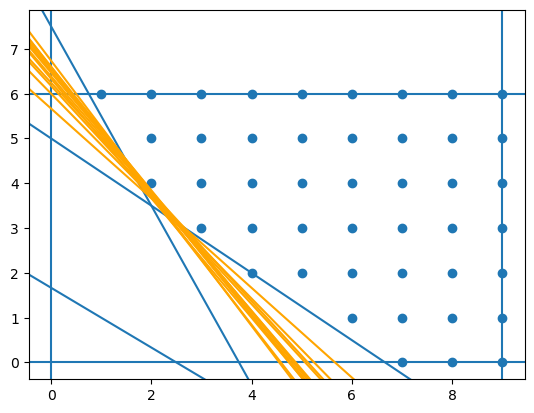

<IPython.core.display.Math object>

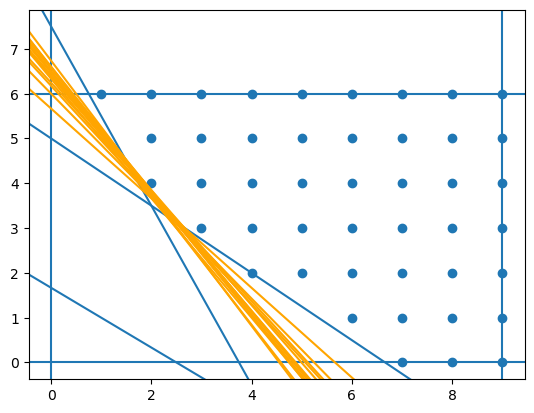

<IPython.core.display.Math object>

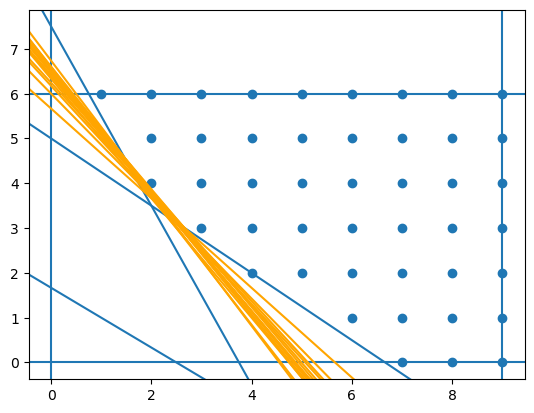

<IPython.core.display.Math object>

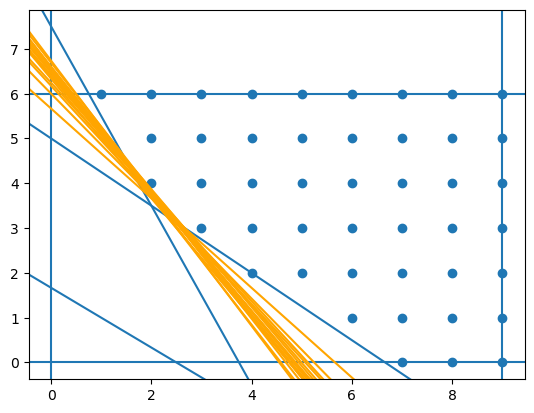

<IPython.core.display.Math object>

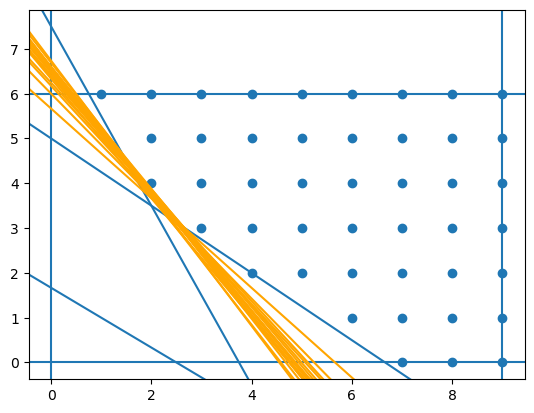

<IPython.core.display.Math object>

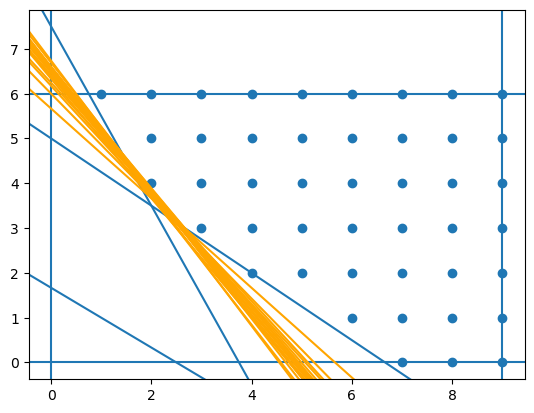

<IPython.core.display.Math object>

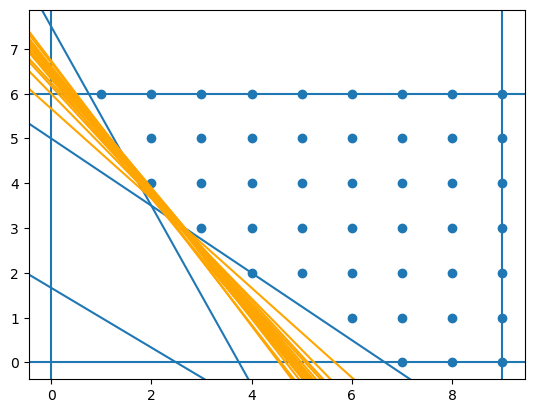

<IPython.core.display.Math object>

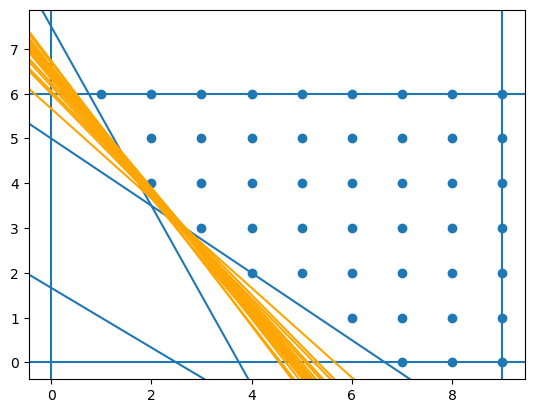

<IPython.core.display.Math object>

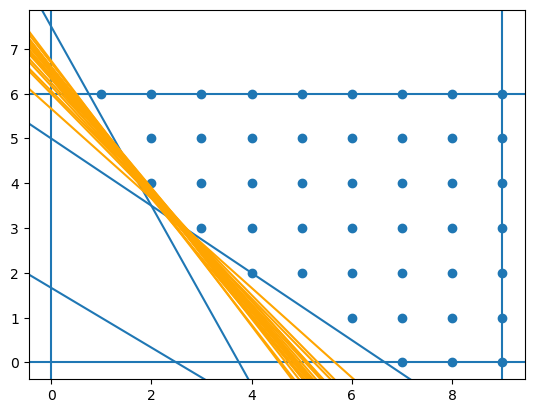

<IPython.core.display.Math object>

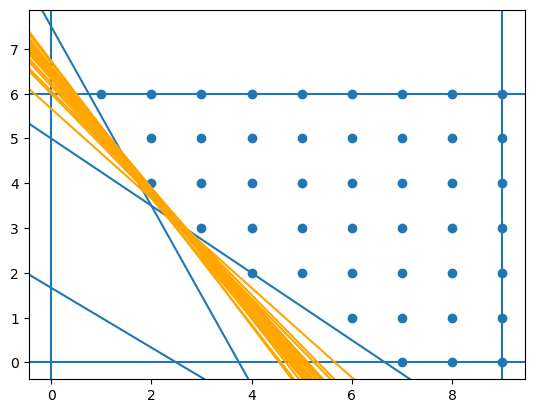

<IPython.core.display.Math object>

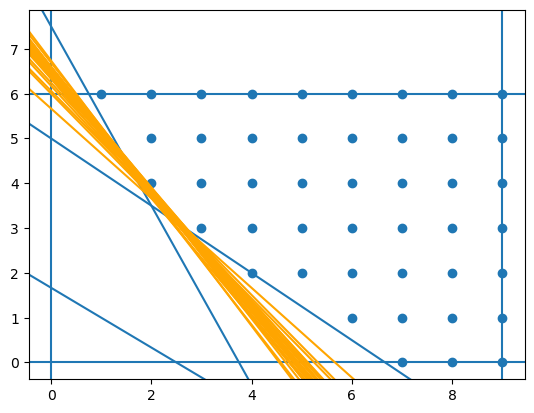

<IPython.core.display.Math object>

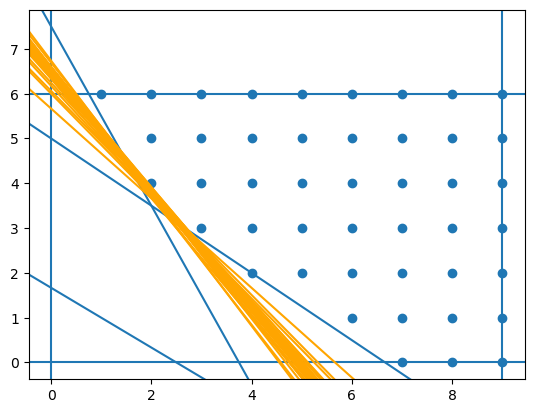

<IPython.core.display.Math object>

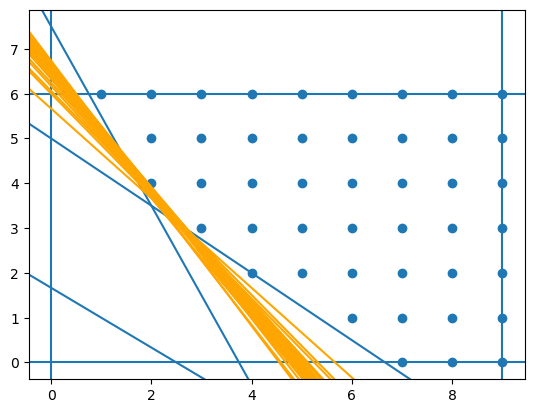

<IPython.core.display.Math object>

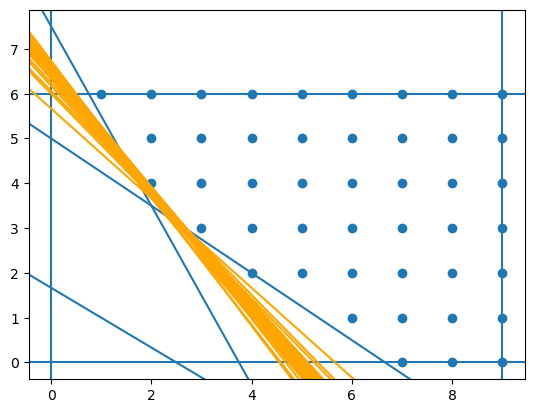

<IPython.core.display.Math object>

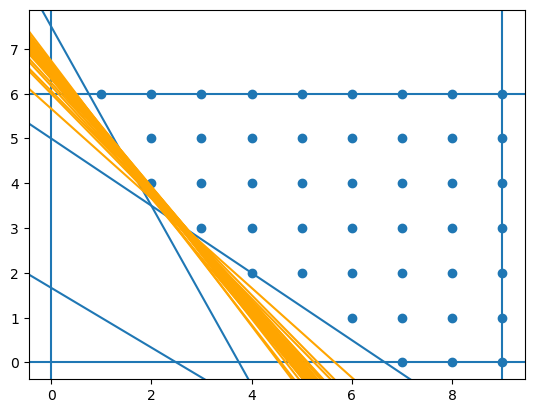

<IPython.core.display.Math object>

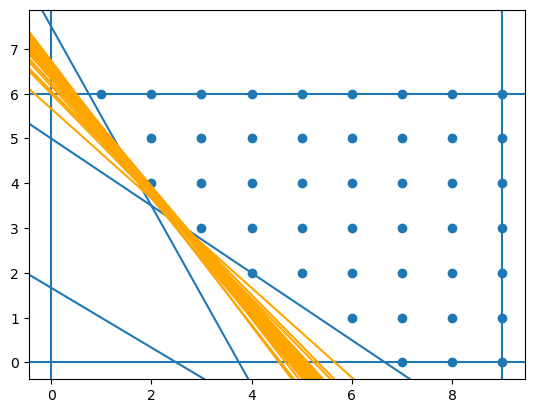

<IPython.core.display.Math object>

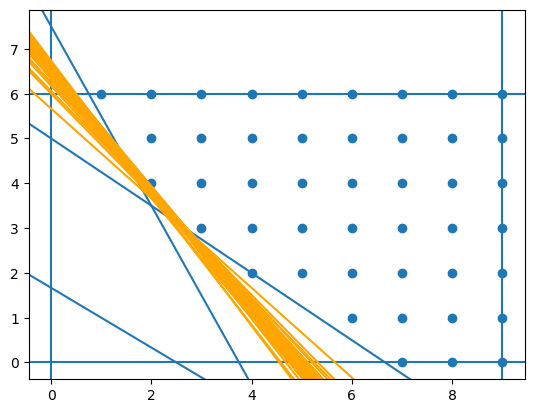

<IPython.core.display.Math object>

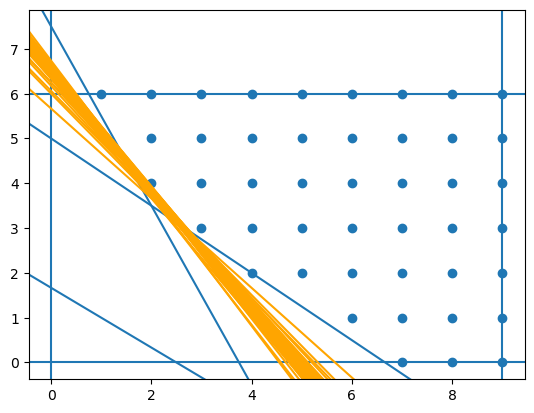

<IPython.core.display.Math object>

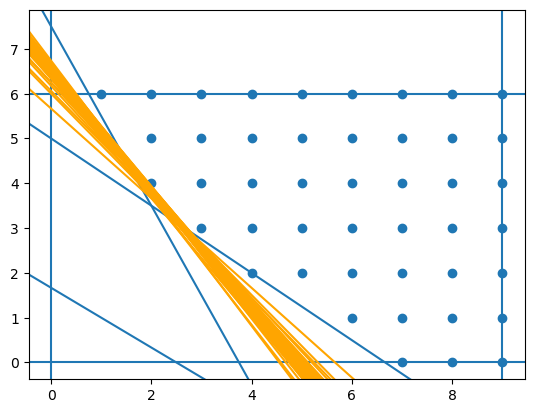

<IPython.core.display.Math object>

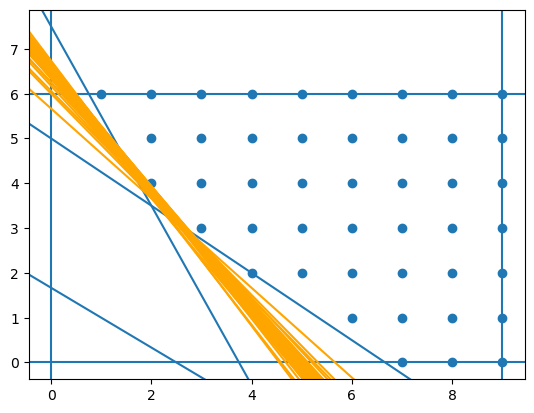

<IPython.core.display.Math object>

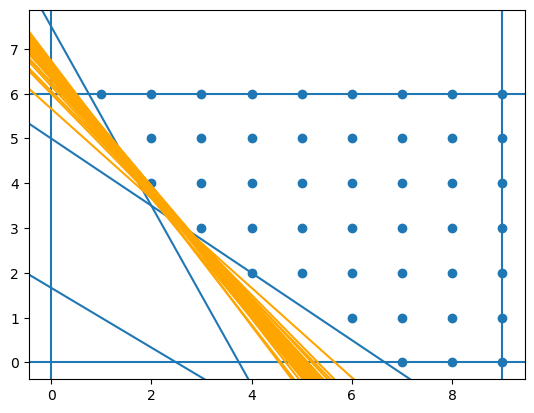

<IPython.core.display.Math object>

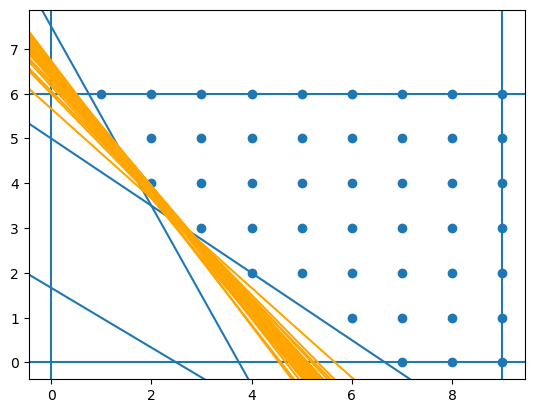

<IPython.core.display.Math object>

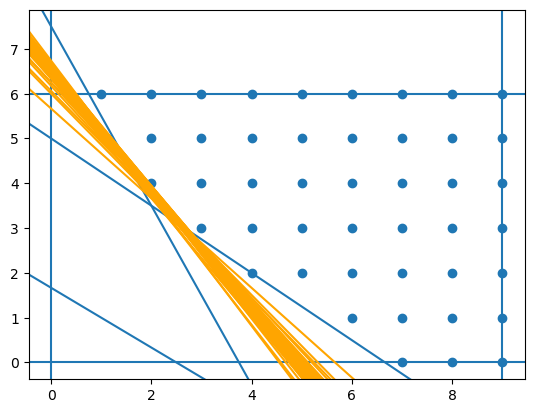

<IPython.core.display.Math object>

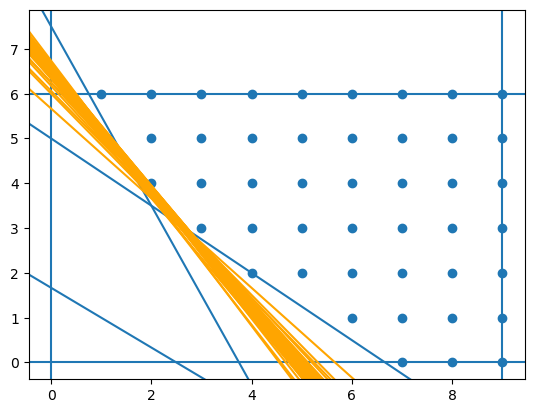

<IPython.core.display.Math object>

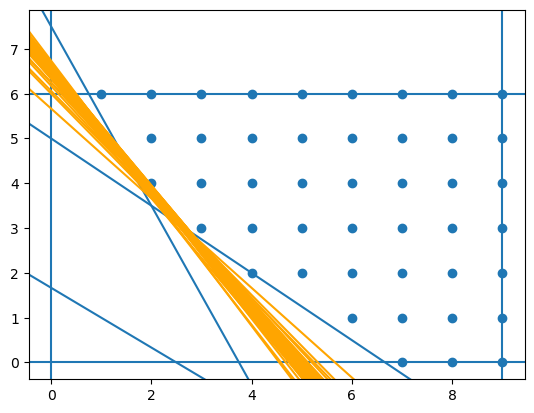

<IPython.core.display.Math object>

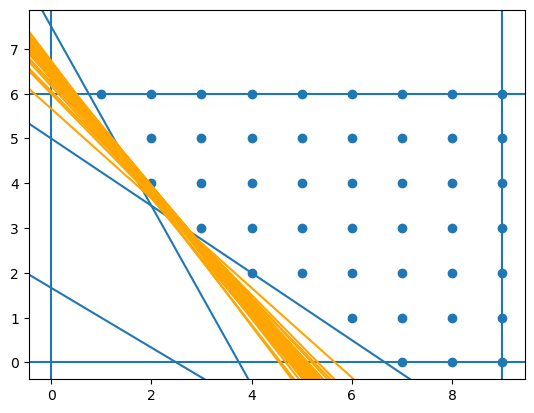

<IPython.core.display.Math object>

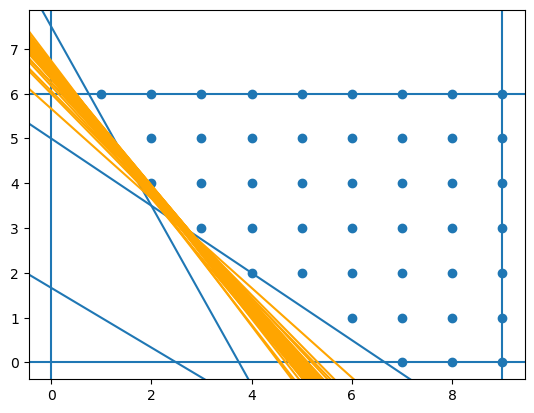

<IPython.core.display.Math object>

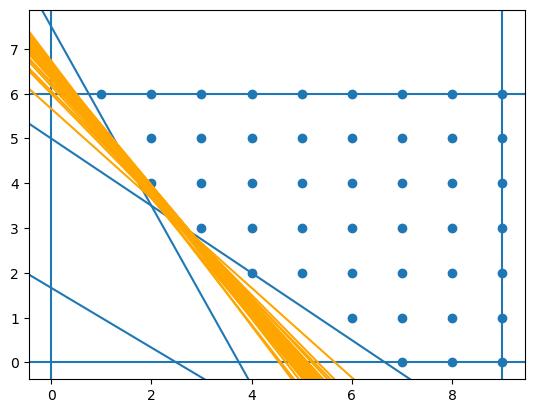

<IPython.core.display.Math object>

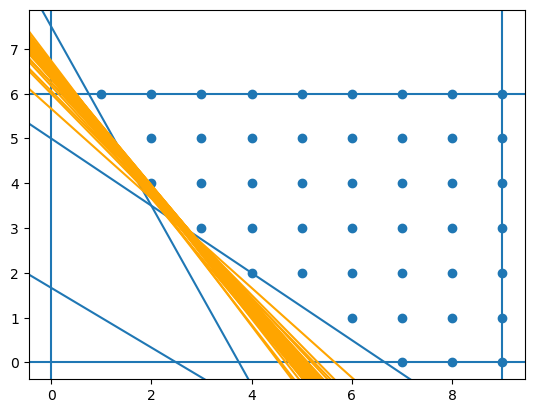

<IPython.core.display.Math object>

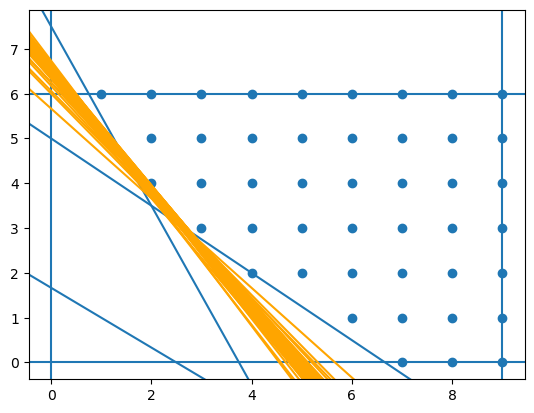

<IPython.core.display.Math object>

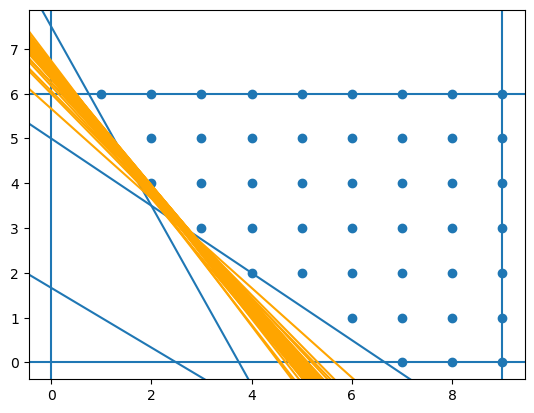

<IPython.core.display.Math object>

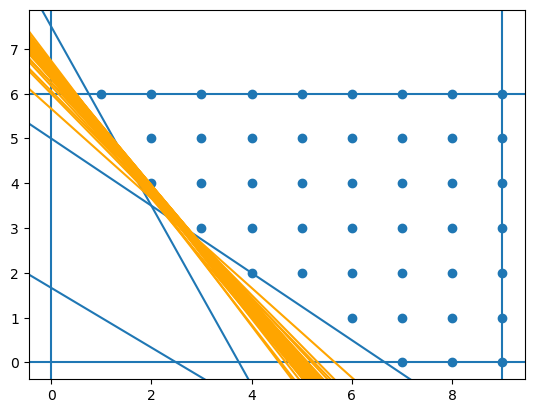

<IPython.core.display.Math object>

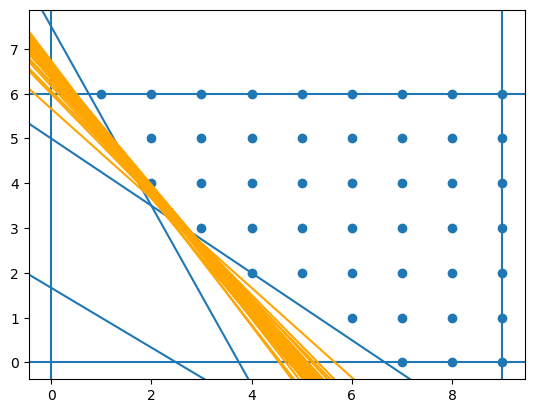

<IPython.core.display.Math object>

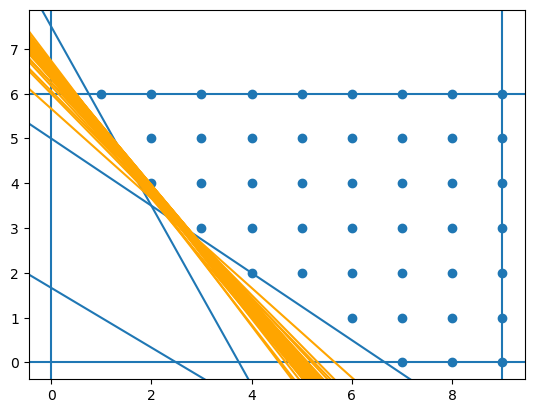

<IPython.core.display.Math object>

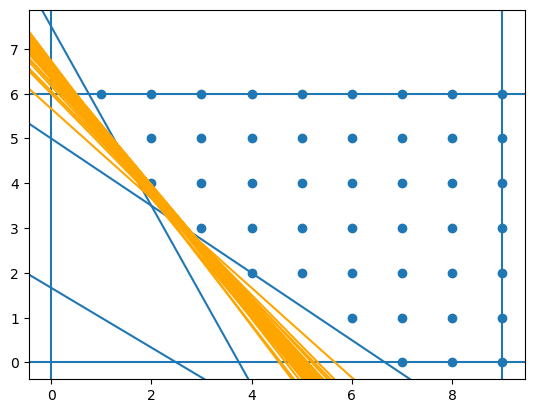

<IPython.core.display.Math object>

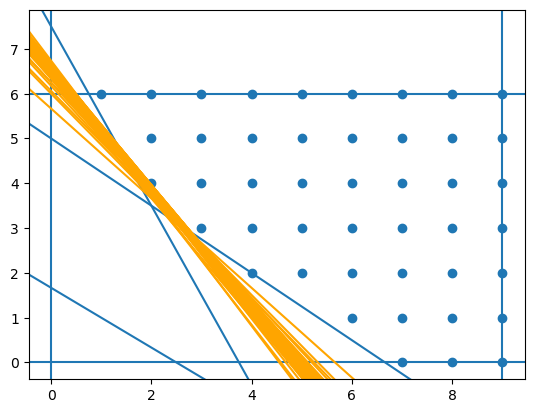

<IPython.core.display.Math object>

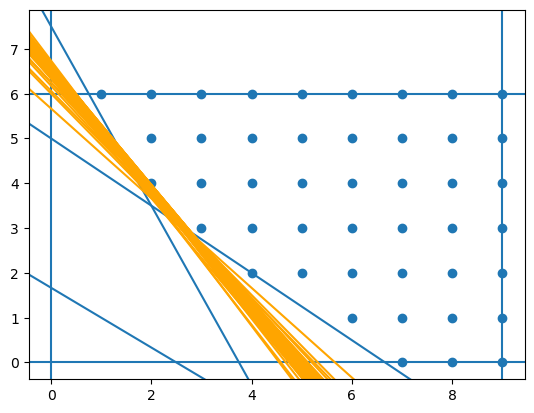

<IPython.core.display.Math object>

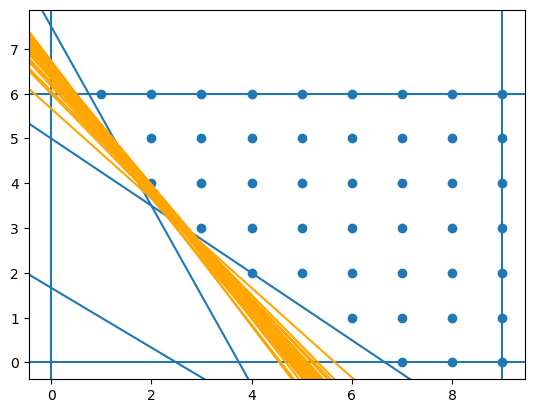

<IPython.core.display.Math object>

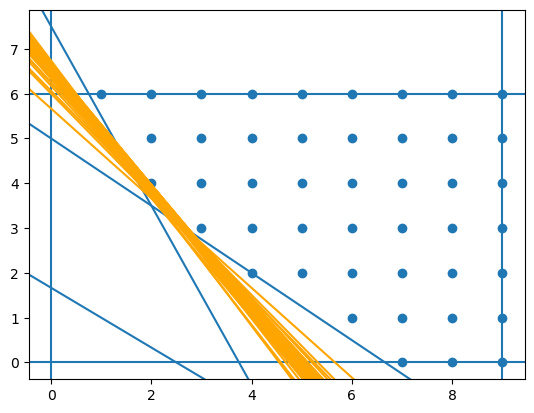

<IPython.core.display.Math object>

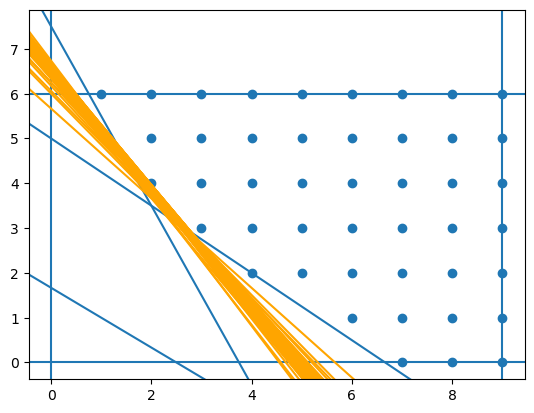

<Figure size 640x480 with 0 Axes>

In [25]:
cut = compute_gomory_cut(dbug)
count = 0
while cut != 'integral' and count < 50:
    count += 1
    ocut = dbug.to_original_vars(*cut)
    bug_cuts.append(ocut)
    dbug.add_cut(*cut)
    while not dbug.is_primal_feasible():
        if dbug.dual_simplex_step() == 'infeasible':
            raise RuntimeError("INFEASIBLE")
    dbug.display()
    plot_2d_integer_system(Abug, bbug, (0,20), (0,20), cuts=bug_cuts)
    plt.show()
    plt.clf()

In [26]:
print("x_1 ~", float(dbug.bas_vals[1]))

x_1 ~ 2.2905812493456863


In [27]:
print("x_2 ~", float(dbug.bas_vals[2]))

x_2 ~ 3.5789390629907354
